In [6]:
import IPython.display as display
import time
import os
import shutil
import cv2
import PIL.Image

import tensorflow as tf
import numpy as np

try:
    shutil.rmtree("./sample_data")
except:
    pass

In [7]:
def tensor_to_image(tensor):
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

In [8]:
def load_img(path, max_dim=None, resize=True):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    if resize:
        new_shape = tf.cast([256, 256], tf.int32)
        img = tf.image.resize(img, new_shape)

    if max_dim:
        shape = tf.cast(tf.shape(img)[:-1], tf.float32)
        long_dim = max(shape)
        scale = max_dim / long_dim
        new_shape = tf.cast(shape * scale, tf.int32)
        img = tf.image.resize(img, new_shape)

    img = img[tf.newaxis, :]

    return img

In [9]:
def resolve_video(network, path, result):
    cap = cv2.VideoCapture(path)
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWrite(result, fourcc, 30.0, (640, 640))

    while cap.isOpened():
        ret, frame = cap.read()

        print('Transferring Video.......')
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RBG)
        frame = tf.cast(frame[tf.newaxis, ...], tf.float32) / 255.0

        prediction = network(frame)

        prediction = clip_0_1(prediction)
        prediction = np.array(prediction).astype(np.uint8).squeeze()
        prediction = cv2.cvtColor(prediction, cv2.COLOR_BG2BGR)

        if cv2.waitKey(1) & 0xFF == org('q'):
            break
        
    cap.release()
    out.release()
    cv2.destroyALLWindow()

def create_folder(dirname):
    if not os.path.exists(dirname):
        os.mkdir(dirname)
        print('Directory ', dirname, ' created')
    else:
        print('Directory', dirname, ' already exists')
    
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=255.0)

In [10]:
class InstanceNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-3):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon

    def build(self, input_shape):
        self.beta = tf.Variable(tf.zeros([input_shape[3]]))
        self.gamma = tf.Variable(tf.ones([input_shape[3]]))

    def call(self, inputs):
        mean, var = tf.nn.moments(inputs, axes=[1, 2], keepdims=True)
        x = tf.divide(tf.subtract(inputs, mean), tf.sqrt(tf.add(var, self.epsilon)))

        return self.gamma * x + self.beta

In [11]:
class InstanceNormConv2D(tf.keras.layers.Layer):
    def __init__(self, filters, kernel, stride):
        super(InstanceNormConv2D, self).__init__()
        pad = kernel // 2
        self.padding = tf.constant([[0, 0], [pad, pad], [pad, pad], [0, 0]])
        self.conv = tf.keras.layers.Conv2D(filters, kernel, stride, use_bias=False, padding='valid')
        self.instance_norm = InstanceNormalization()

    def call(self, inputs, relu=True):
        x = tf.pad(inputs, self.padding, mode='REFLECT')
        x = self.conv(x)
        x = self.instance_norm(x)

        if relu:
            x = tf.keras.layers.Activation("relu")(x)
        return x

In [12]:
class ResizableConv2D(tf.keras.layers.Layer):
    def __init__(self, filters, kernel, stride):
        super(ResizableConv2D, self).__init__()
        self.conv = InstanceNormConv2D(filters, kernel, stride)
        self.stride = stride

    def call(self, inputs):
        height = inputs.shape[1] * self.stride * 2
        width = inputs.shape[2] * self.stride * 2
        x = tf.image.resize(inputs, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        x = self.conv(x)
        return x

In [13]:
class InstanceNormConv2DTranspose(tf.keras.layers.Layer):
    def __init__(self, filters, kernel, stride):
        super(InstanceNormConv2DTranspose, self).__init__()
        self.conv_transpose = tf.keras.layers.Conv2DTranspose(filters, kernel, stride, padding="same")
        self.instance_norm = InstanceNormalization()

    def call(self, inputs):
        x = self.conv_transpose(inputs)
        x = self.instance_norm(x)
        return tf.keras.layers.Activation("relu")

In [14]:
class Residual(tf.keras.layers.Layer):
    def __init__(self, filters, kernel, stride):
        super(Residual, self).__init__()
        self.conv1 = InstanceNormConv2D(filters, kernel, stride)
        self.conv2 = InstanceNormConv2D(filters, kernel, stride)

    def call(self, inputs):
        x = self.conv1(inputs)
        return inputs + self.conv2(x, relu=False)

In [15]:
class TransformerNet(tf.keras.models.Model):
    def __init__(self):
        super(TransformerNet, self).__init__()
        self.conv1 = InstanceNormConv2D(filters=32, kernel=9, stride=1)
        self.conv2 = InstanceNormConv2D(filters=64, kernel=3, stride=2)
        self.conv3 = InstanceNormConv2D(filters=128, kernel=3, stride=2)

        self.res1 = Residual(filters=128, kernel=3, stride=1)
        self.res2 = Residual(filters=128, kernel=3, stride=1)
        self.res3 = Residual(filters=128, kernel=3, stride=1)
        self.res4 = Residual(filters=128, kernel=3, stride=1)
        self.res5 = Residual(filters=128, kernel=3, stride=1)

        self.resize_conv1 = ResizableConv2D(filters=64, kernel=3, stride=2) 
        self.resize_conv2 = ResizableConv2D(filters=32, kernel=3, stride=2) 
        self.conv4 = InstanceNormConv2D(filters=3, kernel=9, stride=1)

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)
        x = self.res4(x)
        x = self.res5(x)
        x = self.resize_conv1(x)
        x = self.resize_conv2(x)
        x = self.conv4(x, relu=False)

        return (tf.keras.activations.tanh(x) * 150 + 255.0 / 2)

In [ ]:
CONTENT_WEIGHT = 6e0
STYLE_WEIGHT = 2e-3
TV_WEIGHT = 6e2
LEARNING_RATE = 1e-3
NUM_EPOCHS = 2
BATCH_SIZE = 2

DATASET_PATH = "./drive/MyDrive/COCO-dataset/train2014"
# MODEL_PATH = "./drive/MyDrive/Fast-Style-Transfer/models/scream/model/"
# WEIGHTS_PATH = "./drive/MyDrive/Fast-Style-Transfer/models/scream/weights/"
# STYLE_IMAGE = "./drive/MyDrive/Fast-Style-Transfer/images/style/the_scream.jpg"
# RESULT_NAME = "./drive/MyDrive/Fast-Style-Transfer/Result.jpg"

In [ ]:
def vgg_layers(layer_names):
    vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(layer).output for layer in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

In [ ]:
def gram_matrix(feature_map, normalize=True):
    gram = tf.linalg.einsum('bijc,bijd->bcd', feature_map, feature_map)
    if normalize:
        input_shape = tf.shape(feature_map)
        gram /= tf.cast(input_shape[1] * input_shape[2], tf.float32)
    
    return gram

In [ ]:
def style_loss(style_outputs, style_target):
    loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_target[name]) ** 2) for name in style_outputs.keys()])
    return loss

def content_loss(content_outputs, content_target):
    loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_target[name]) ** 2) for name in content_outputs.keys()])
    return loss

In [ ]:
def total_variation_loss(img):
    x = img[:, :, 1:, :] - img[:, :, :-1, :]
    y = img[:, 1:, :, :] - img[:, :-1, :, :]

    return tf.reduce_mean(tf.square(x)) + tf.reduce_mean(tf.square(y))

In [ ]:
class VGG19LossModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(VGG19LossModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.num_content_layers = len(content_layers)
        self.vgg.trainable = False
    
    def call(self, inputs):
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])
        

        style_outputs = [gram_matrix(feature_map) for feature_map in style_outputs]

        style_dict = {
            style_name: value for style_name, value in zip(self.style_layers, style_outputs)
        }

        content_dict = {
            content_name: value for content_name, value in zip(self.content_layers, content_outputs)
        }

        return {
            'content' : content_dict,
            'style': style_dict
        }

In [ ]:
train_dataset = tf.data.Dataset.list_files(DATASET_PATH + '/*.jpg')

In [ ]:
train_dataset = train_dataset.map(load_img, num_parallel_calls = tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(1024)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
# # THE SCREAM.jpg

# content_layers = ['block4_conv2']
# style_layers = ['block1_conv1',
#                 'block2_conv1',
#                 'block3_conv1',
#                 'block4_conv1',
#                 'block5_conv1']

# transformer_net = TransformerNet()
# # transformer_net = tf.keras.models.load_weights(MODEL_PATH)
# extractor = VGG19LossModel(style_layers, content_layers)

# style_image = load_img(STYLE_IMAGE, resize = False)
# input_shape = (BATCH_SIZE, 256, 256, 3)

# X_batch = np.zeros(input_shape, dtype=np.float32)

# style_target = extractor(style_image * 255.0)['style']

# optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

# loss_metric = tf.keras.metrics.Mean()
# sloss_metric = tf.keras.metrics.Mean()
# closs_metric = tf.keras.metrics.Mean()
# tvloss_metric = tf.keras.metrics.Mean()

# @tf.function()
# def train_step(X_batch):
#     with tf.GradientTape() as tape:
#         content_target = extractor(X_batch * 255.0)['content']
#         image = transformer_net(X_batch)
#         outputs = extractor(image)

#         sloss = STYLE_WEIGHT * style_loss(outputs['style'], style_target)
#         closs = CONTENT_WEIGHT * content_loss(outputs['content'], content_target)
#         tvloss = TV_WEIGHT * total_variation_loss(image)
#         loss = sloss + closs + tvloss

#     gradients = tape.gradient(loss, transformer_net.trainable_variables)
#     optimizer.apply_gradients(zip(gradients, transformer_net.trainable_variables))

#     loss_metric(loss)
#     sloss_metric(sloss)
#     closs_metric(closs)
#     tvloss_metric(tvloss)

# start = time.time()
# for epoch in range(1, NUM_EPOCHS + 1):
#     print(f'Epoch {epoch}/{NUM_EPOCHS}')
#     iteration = 0
#     progress_bar = tf.keras.utils.Progbar(None, interval=1, unit_name='iteration')
#     for image in train_dataset:
#         for j, img_p in enumerate(image):
#             X_batch[j] = img_p
        
#         iteration += 1
#         train_step(X_batch)
#         progress_bar.add(iteration,
#                         [('loss', loss_metric.result()),
#                           ('style_loss', sloss_metric.result()),
#                           ('content_loss', closs_metric.result()),
#                           ('tv_loss', tvloss_metric.result())])

#         if iteration % 3000 == 0:
#             transformer_net.save_weights(WEIGHTS_PATH, save_format='tf')
#             print(f'step {iteration}: loss = {loss_metric.result()}')
#             print(f'style_loss={sloss_metric.result()}, content_loss={closs_metric.result()}, tv_loss={tvloss_metric.result()}')

# end = time.time()
# print("Time: {:.1f}".format(end - start))

# transformer_net.save_weights(WEIGHTS_PATH, save_format='tf')
# print("Model Trained!")

Epoch 1/2
4501500/Unknown - 844s 163us/iteration - loss: 36510624.0000 - style_loss: 32808590.0000 - content_loss: 3669651.0000 - tv_loss: 32336.2148step 3000: loss = 22943932.0
style_loss=19259954.0, content_loss=3653886.75, tv_loss=30059.724609375
18003000/Unknown - 1574s 81us/iteration - loss: 22576668.0000 - style_loss: 18865174.0000 - content_loss: 3681283.0000 - tv_loss: 30165.8828step 6000: loss = 15324668.0
style_loss=11612195.0, content_loss=3683439.5, tv_loss=28999.0390625
40504500/Unknown - 2430s 57us/iteration - loss: 17630722.0000 - style_loss: 13920391.0000 - content_loss: 3681094.5000 - tv_loss: 29211.8262step 9000: loss = 12521783.0
style_loss=8819048.0, content_loss=3674705.25, tv_loss=28008.96875
72006000/Unknown - 3314s 45us/iteration - loss: 15008471.0000 - style_loss: 11304051.0000 - content_loss: 3675892.7500 - tv_loss: 28506.7656step 12000: loss = 10960621.0
style_loss=7267062.5, content_loss=3666257.25, tv_loss=27284.0390625
112492500/Unknown - 4197s 36us/iterat

In [ ]:
model = TransformerNet()
model.load_weights("./drive/MyDrive/Fast-Style-Transfer/models/scream/weights/")

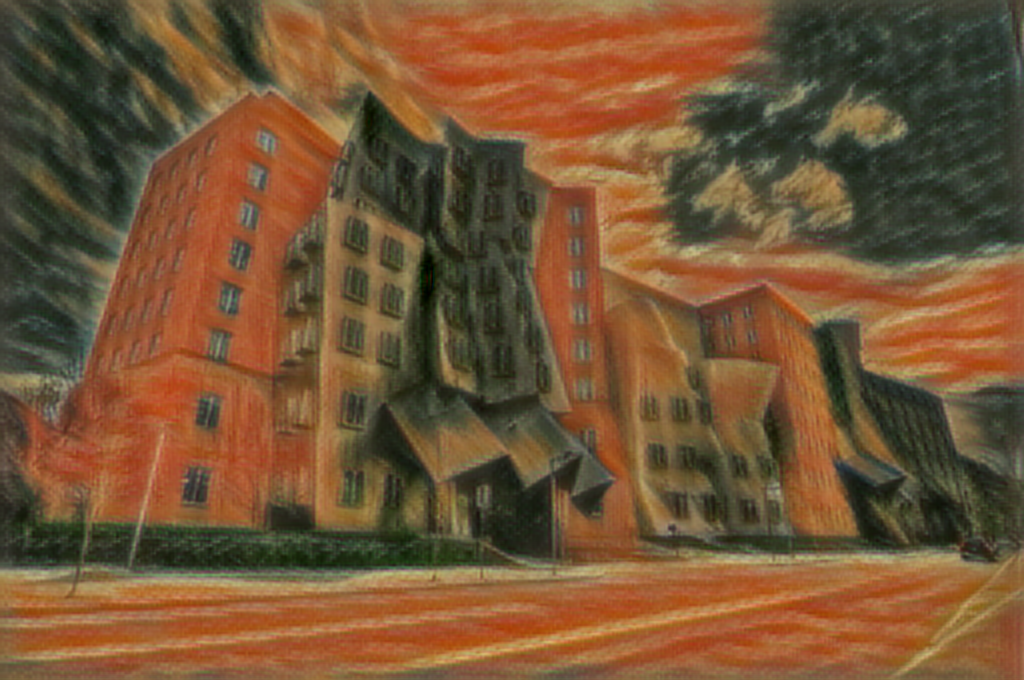

In [ ]:
image_type = ('jpg', 'jpeg', 'png')
CONTENT_PATH = "./drive/MyDrive/Fast-Style-Transfer/images/content/stata.jpg"

image = load_img(CONTENT_PATH, resize=False)
image.shape
if CONTENT_PATH[-3:] in image_type:
  image = load_img(CONTENT_PATH, resize = False)
  image = transformer_net(image)
  image = clip_0_1(image)
  output = tensor_to_image(image)

output

In [ ]:
DATASET_PATH = "./drive/MyDrive/COCO-dataset/train2014"
MODEL_PATH = "./drive/MyDrive/Fast-Style-Transfer/models/wave/model/"
WEIGHTS_PATH = "./drive/MyDrive/Fast-Style-Transfer/models/wave/weights/"
STYLE_IMAGE = "./drive/MyDrive/Fast-Style-Transfer/images/style/wave.jpg"
RESULT_NAME = "./drive/MyDrive/Fast-Style-Transfer/Result.jpg"

In [ ]:
# THE WAVE.jpg

content_layers = ['block4_conv2']
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

transformer_net = TransformerNet()
transformer_net.load_weights(WEIGHTS_PATH)
extractor = VGG19LossModel(style_layers, content_layers)

style_image = load_img(STYLE_IMAGE, resize = False)
input_shape = (BATCH_SIZE, 256, 256, 3)

X_batch = np.zeros(input_shape, dtype=np.float32)

style_target = extractor(style_image * 255.0)['style']

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

loss_metric = tf.keras.metrics.Mean()
sloss_metric = tf.keras.metrics.Mean()
closs_metric = tf.keras.metrics.Mean()
tvloss_metric = tf.keras.metrics.Mean()

@tf.function()
def train_step(X_batch):
    with tf.GradientTape() as tape:
        content_target = extractor(X_batch * 255.0)['content']
        image = transformer_net(X_batch)
        outputs = extractor(image)

        sloss = STYLE_WEIGHT * style_loss(outputs['style'], style_target)
        closs = CONTENT_WEIGHT * content_loss(outputs['content'], content_target)
        tvloss = TV_WEIGHT * total_variation_loss(image)
        loss = sloss + closs + tvloss

    gradients = tape.gradient(loss, transformer_net.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer_net.trainable_variables))

    loss_metric(loss)
    sloss_metric(sloss)
    closs_metric(closs)
    tvloss_metric(tvloss)

start = time.time()
for epoch in range(1, NUM_EPOCHS + 1):
    print(f'Epoch {epoch}/{NUM_EPOCHS}')
    iteration = 0
    progress_bar = tf.keras.utils.Progbar(None, interval=1, unit_name='iteration')
    for image in train_dataset:
        for j, img_p in enumerate(image):
            X_batch[j] = img_p
        
        iteration += 1
        train_step(X_batch)
        progress_bar.add(iteration,
                        [('loss', loss_metric.result()),
                          ('style_loss', sloss_metric.result()),
                          ('content_loss', closs_metric.result()),
                          ('tv_loss', tvloss_metric.result())])

        if iteration % 3000 == 0:
            transformer_net.save_weights(WEIGHTS_PATH, save_format='tf')
            print(f'\n\nstep {iteration}: loss = {loss_metric.result()}')
            print(f'style_loss={sloss_metric.result()}, content_loss={closs_metric.result()}, tv_loss={tvloss_metric.result()}')

end = time.time()
print("Time: {:.1f}".format(end - start))

transformer_net.save_weights(WEIGHTS_PATH, save_format='tf')
print("Model Trained!")

80142336/80134624 [==============================] - 2s 0us/step
Epoch 1/2
4501500/Unknown - 2925s 592us/iteration - loss: 6777248.0000 - style_loss: 2267944.5000 - content_loss: 4163699.0000 - tv_loss: 345598.3750

step 3000: loss = 6774074.5
style_loss=2266141.25, content_loss=4162568.75, tv_loss=345358.40625
18003000/Unknown - 5605s 297us/iteration - loss: 6767532.0000 - style_loss: 2262134.0000 - content_loss: 4159992.0000 - tv_loss: 345391.4062

step 6000: loss = 6759745.5
style_loss=2256714.0, content_loss=4157682.75, tv_loss=345339.875
40495500/Unknown - 8267s 198us/iteration - loss: 6755982.0000 - style_loss: 2255606.5000 - content_loss: 4155080.0000 - tv_loss: 345281.4062

step 9000: loss = 6736642.5
style_loss=2243276.0, content_loss=4148184.5, tv_loss=345187.0
71994000/Unknown - 10947s 148us/iteration - loss: 6748078.5000 - style_loss: 2251791.2500 - content_loss: 4150997.5000 - tv_loss: 345280.5625

step 12000: loss = 6732057.5
style_loss=2240557.75, content_loss=4146299.25

In [ ]:
model = TransformerNet()
model.load_weights("./drive/MyDrive/Fast-Style-Transfer/models/wave/weights/")